In [13]:
import torch
import torch.nn as nn

class DP_SGD(nn.Module):

    def __init__(self):
        super(DP_SGD, self).__init__()
        
        self.flat = nn.Flatten()
        self.l1 = nn.Linear(784, 392)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(392, 10)
        self.sm = nn.Softmax()

    def forward(self, x):
        
        x = self.flat(x)
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.sm(x)
        
        return x

In [14]:
MAX_GRAD_NORM = 1.2
EPSILON = 50.0
DELTA = 1e-5
EPOCHS = 10

LR = 1e-3

BATCH_SIZE = 512
MAX_PHYSICAL_BATCH_SIZE = 128

In [15]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms



DATA_ROOT = '../mnist'

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = MNIST(
    root=DATA_ROOT, train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
)

test_dataset = MNIST(
    root=DATA_ROOT, train=False, download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

print(len(train_dataset))
dataiter = iter(train_loader)
images, labels = next(dataiter)
images[0].size()

60000


torch.Size([1, 28, 28])

In [16]:
import numpy as np
import torch.optim as optim
from opacus.utils.batch_memory_manager import BatchMemoryManager


def train(model, train_loader, optimizer, epoch, device):
    model.train()
    criterion = nn.CrossEntropyLoss()

    losses = []
    top1_acc = []
    
    with BatchMemoryManager(
        data_loader=train_loader, 
        max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE, 
        optimizer=optimizer
    ) as memory_safe_data_loader:

        for i, (images, target) in enumerate(memory_safe_data_loader):   
            optimizer.zero_grad()
            images = images.to(device)
            target = target.to(device)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()

            # measure accuracy and record loss
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

            loss.backward()
            optimizer.step()
            

            if (i+1) % 200 == 0:
                epsilon = privacy_engine.get_epsilon(DELTA)
                print(
                    f"\tTrain Epoch: {epoch} \t"
                    f"Loss: {np.mean(losses):.6f} "
                    f"Acc@1: {np.mean(top1_acc) * 100:.6f} "
                    f"(ε = {epsilon:.5f}, δ = {DELTA})"
                )
    return np.mean(top1_acc), epsilon
    

In [17]:
def test(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    losses = []
    top1_acc = []

    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

    top1_avg = np.mean(top1_acc)

    print(
        f"\tTest set:"
        f"Loss: {np.mean(losses):.6f} "
        f"Acc: {top1_avg * 100:.6f} "
    )
    return np.mean(top1_acc)


from tqdm.notebook import tqdm

report = []

def accuracy(preds, labels):
    return (preds == labels).mean()

#for epoch in tqdm(range(EPOCHS), desc="Epoch", unit="epoch"):
#    results = train(model, train_loader, optimizer, epoch + 1, device)
#    report.append(results)

In [18]:
acc = []
e = []
for i in report:
    acc.append(i[0])
    e.append(i[1])

In [19]:
gen_args = {'a1': 0.1, 'a3': 0.4, 'a4': 0.9, 'G_theta': 1, 'G_k': 2, 'E_lambda': 5, 'U_b': 2, 'U_a': 1, 'delta': 1e-05, 'overall_epsilon': 0.9479105959893149}
args ={
            "a1":gen_args['a1'],
            "a3":gen_args['a3'],
            "a4":gen_args['a4'],
            "lam":gen_args['E_lambda'],
            "moment":1,
            "theta":gen_args['G_theta'],
            'k':gen_args['G_k'],
            'mu':0,
            'sigma':0.5,
            'a':gen_args['U_a'],
            'b':gen_args['U_b'],
            'u':1,
            'l':0.1,
            'epsilon':1,
            'max_grad_norm': 1,
        }

#### 

In [25]:
a = [2.0399534702301025,
 2.0785865783691406,
 0.286745548248291,
 0.3862180709838867,
 0.5440805554389954,
 0.23060685396194458,
 0.6175987720489502,
 0.21684515476226807,
 1.100000023841858]
args ={
            "a1":1,
            "a3":1,
            "a4":1,
            "lam":a[8],
            "moment":a[8],
            'k':a[0],
            "theta":a[1],
            'a':a[2],
            'b':a[3],
            'mu':a[4],
            'sigma':a[5],
            'u':a[6],
            'l':a[7],
            'epsilon':0.3,
            'max_grad_norm': 5,
            'gamma':True,
            'uniform':True,
            'truncnorm':True,
        }

In [26]:
from opacus import PrivacyEngine
from torch import nn
from torchvision import models

runs = []
trun = []

model = DP_SGD()
#model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
from opacus.validators import ModuleValidator

model = ModuleValidator.fix(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
    
privacy_engine = PrivacyEngine(accountant = 'rdp_plrv')
    
optimizer = optim.RMSprop(model.parameters(), lr=LR)

model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        noise_multiplier = 1,
        epochs=EPOCHS,
        target_epsilon=0.3,
        target_delta=DELTA,
        max_grad_norm=0.0001,
        PLRV_args=args,
)
    
plrv_report_acc = []
plrv_report_ep = []

for epoch in tqdm(range(2), desc="Epoch", unit="epoch"):
    acc, ep = train(model, train_loader, optimizer, epoch + 1, device)
    plrv_report_acc.append(acc)
    plrv_report_ep.append(ep)
    
del model
del optimizer
#del results
torch.cuda.empty_cache()

Epoch:   0%|          | 0/2 [00:00<?, ?epoch/s]

151  151
	Train Epoch: 1 	Loss: 2.303302 Acc@1: 10.409356 (ε = 0.10287, δ = 1e-05)
151  151
	Train Epoch: 1 	Loss: 2.302682 Acc@1: 11.347589 (ε = 0.10287, δ = 1e-05)
151  151
	Train Epoch: 2 	Loss: 2.301361 Acc@1: 14.097746 (ε = 0.10287, δ = 1e-05)
151  151
	Train Epoch: 2 	Loss: 2.301410 Acc@1: 14.140012 (ε = 0.10287, δ = 1e-05)


In [10]:
from opacus import PrivacyEngine
from torch import nn
runs = []
trun = []

model = DP_SGD()
from opacus.validators import ModuleValidator

model = ModuleValidator.fix(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
    
privacy_engine = PrivacyEngine(accountant = 'rdp')
    
optimizer = optim.RMSprop(model.parameters(), lr=LR)

model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        #noise_multiplier = 0.0051189550030173656,
        epochs=2,
        target_epsilon=0.3,
        target_delta=DELTA,
        max_grad_norm=1,
        #PLRV_args=args,
)
    
rdp_report_acc = []
rdp_report_ep = []

for epoch in tqdm(range(2), desc="Epoch", unit="epoch"):
    acc, ep = train(model, train_loader, optimizer, epoch + 1, device)
    rdp_report_acc.append(acc)
    rdp_report_ep.append(ep)
    

del model
del optimizer
#del results
torch.cuda.empty_cache()

/home/knil/Documents/NextCloud/RAstuff/opacus/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Epoch:   0%|          | 0/2 [00:00<?, ?epoch/s]

	Train Epoch: 1 	Loss: 2.154856 Acc@1: 55.976827 (ε = 0.21184, δ = 1e-05)
	Train Epoch: 1 	Loss: 2.027461 Acc@1: 65.010809 (ε = 0.23158, δ = 1e-05)
	Train Epoch: 2 	Loss: 1.756732 Acc@1: 80.969115 (ε = 0.26161, δ = 1e-05)
	Train Epoch: 2 	Loss: 1.738462 Acc@1: 81.924209 (ε = 0.28092, δ = 1e-05)


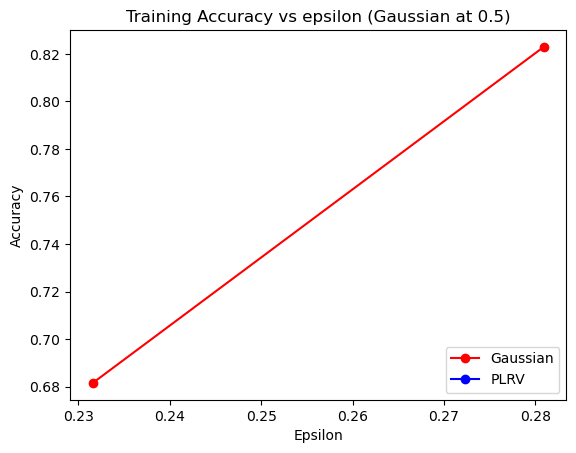

In [11]:
import matplotlib.pyplot as plt   
plt.plot(rdp_report_ep, rdp_report_acc, 'ro-', label="Gaussian")
plt.plot(plrv_report_ep, plrv_report_acc, 'bo-', label="PLRV")
plt.legend(loc="lower right")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs epsilon (Gaussian at 0.5)")
plt.show()

ValueError: x and y must have same first dimension, but have shapes (10,) and (2,)

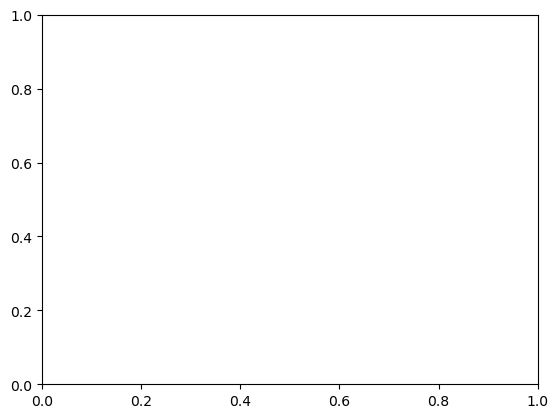

In [12]:
import matplotlib.pyplot as plt   
plt.plot(range(EPOCHS), rdp_report_acc, 'ro-', label="Gaussian")
plt.plot(range(EPOCHS), plrv_report_acc, 'bo-', label="PLRV")
plt.legend(loc="lower right")
plt.xticks(range(EPOCHS))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs epsilon (Clipping = 50)")
plt.show()

In [ ]:
plrv_report_acc

In [ ]:
import matplotlib.pyplot as plt
labels = [0.3, 0.5, 1, 2]


In [ ]:
results_rdp = []
for i in labels:
    from opacus import PrivacyEngine
    runs = []
    trun = []

    model = DP_GSD()
    from opacus.validators import ModuleValidator

    model = ModuleValidator.fix(model)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    privacy_engine = PrivacyEngine(accountant = 'rdp')

    optimizer = optim.RMSprop(model.parameters(), lr=LR)

    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
            module=model,
            optimizer=optimizer,
            data_loader=train_loader,
            #noise_multiplier = 1,
            epochs=EPOCHS,
            target_epsilon=i,
            target_delta=DELTA,
            max_grad_norm=50,
            #PLRV_args=args,
    )

    rdp_report_acc = []
    rdp_report_ep = []

    for epoch in tqdm(range(EPOCHS), desc="Epoch", unit="epoch"):
        acc, ep = train(model, train_loader, optimizer, epoch + 1, device)
        rdp_report_acc.append(acc)
        rdp_report_ep.append(ep)


    del model
    del optimizer
    #del results
    torch.cuda.empty_cache()
    reprt_rdp.append(test(model, test_loader, device))

In [ ]:
import matplotlib.pyplot as plt
labels = ["run 1","run 2","run 3","run 4","run 5"]
for j in range(len(runs)):
    acc = []
    e = []
    for i in runs[j]:
        acc.append(i[0])
        e.append(i[1])
    
    plt.plot(acc, e, label=labels[j])
    
plt.legend(loc="lower right")
#plt.xticks(range(10))
plt.xlabel("Accuracy")
plt.ylabel("Epsilon")
plt.title("Training Accuracy per Epoch for different values of Maximum Epsilon")
plt.show()

In [ ]:
x = range
y=[]
for i in runs:
    y.append(i[-1][0])

plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Final Accuracy vs Epsilon")
plt.plot(x, trun, 'ro-', label="Testing Acc")
plt.legend(loc="lower right")
plt.show()

In [ ]:
runs = []
trun = []

for i in [0.2, 0.3, 0.5, 1, 2]:
    model = DP_GSD()

    from .opacus.validators import ModuleValidator

    model = ModuleValidator.fix(model)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    
    privacy_engine = PrivacyEngine()
    
    optimizer = optim.RMSprop(model.parameters(), lr=LR)

    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        epochs=i,
        target_epsilon=1,
        target_delta=DELTA,
        max_grad_norm=2,
    )
    
    report = []

    for epoch in tqdm(range(i), desc="Epoch", unit="epoch"):
        results = train(model, train_loader, optimizer, epoch + 1, device)
        report.append(results)
    
    runs.append(report)
    trun.append(test(model, test_loader, device))
    del model

In [ ]:
x = [0.2, 0.3, 0.5, 1, 2]
y=[]
for i in runs:
    y.append(i[-1][0])

plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
#plt.title("Final Accuracy vs Epochs with Epsilon = 2")
plt.plot(x, y, 'bo-', label="Training Acc")
plt.plot(x, trun, 'ro-', label="Testing Acc")
plt.legend(loc="lower right")
plt.show()

In [ ]:
import torch

In [ ]:
from opacus.optimizers.optimizer import _check_processed_flag, _mark_as_processed, DPOptimizer
from torch.distributions.laplace import Laplace
from torch.distributions.gamma import Gamma
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from torch import stack, zeros, einsum
from opacus.optimizers.utils import params
from torch import nn
from torch.optim import Optimizer
from scipy.stats import truncnorm, expon

class PLRVDPOptimizer():
    """
    Implementation of PLRV first noise mechanism.
    """
        
    def make_noise(self, args):
        self.args = args
        self.k = self.args['k']
        self.theta = self.args['theta']
        self.mu = self.args['mu']
        self.sigma = self.args['sigma']
        self.a = self.args['a']
        self.b = self.args['b']
        self.l = self.args['l']
        self.u = self.args['u']
        self.clip = self.args['max_grad_norm']
        self.lam = self.args['lam']
        
        a_transformed, b_transformed = (self.l - self.mu) / self.sigma, (self.u - self.mu) / self.sigma
        
        self.gamma = Gamma(
          concentration = self.k, rate = self.theta
          )
        self.normal= truncnorm(
          a_transformed, b_transformed, loc=self.mu, scale=self.sigma
          )
        self.uniform = Uniform(
          low = self.a, high = self.b
          )
        self.expon = expon(loc=0, scale = 1/self.lam)
    
    
    def add_noise(self):
          
        for p in self.params:
            _check_processed_flag(p.summed_grad)
            
            laplace = self.get_laplace()
            noise = laplace.sample(p.summed_grad.shape).to(p.summed_grad.device)
            p.grad = p.summed_grad + noise

            _mark_as_processed(p.summed_grad)
            
    def get_linear_combination(self):
        gam = self.gamma.sample()
        uni = self.uniform.sample()
        t_norm = self.normal.rvs(size=1)[0]  
        exp = self.expon.rvs(size=1)[0]
        return 1/(self.args['a1']*gam+self.args['a3']*exp+self.args['a4']*uni)
        
    def get_laplace(self):
        return Laplace(loc=0, scale=self.get_linear_combination())
        
    def clip_and_accumulate(self):
        """
        Performs gradient clipping.
        Stores clipped and aggregated gradients into `p.summed_grad```
        """

        if len(self.grad_samples[0]) == 0:
            # Empty batch
            per_sample_clip_factor = zeros(
                (0,), device=self.grad_samples[0].device
            )
        else:
            per_param_norms = [
                g.reshape(len(g), -1).norm(1, dim=-1) for g in self.grad_samples
            ]
            per_sample_norms = stack(per_param_norms, dim=1).norm(1, dim=1)
            per_sample_clip_factor = (
                self.max_grad_norm / (per_sample_norms + 1e-6)
            ).clamp(max=1.0)

        for p in self.params:
            _check_processed_flag(p.grad_sample)
            grad_sample = self._get_flat_grad_sample(p)
            grad = einsum("i,i...", per_sample_clip_factor, grad_sample)

            if p.summed_grad is not None:
                p.summed_grad += grad
            else:
                p.summed_grad = grad

            _mark_as_processed(p.grad_sample)

In [ ]:
noise = PLRVDPOptimizer()
noise.make_noise(args)
laplace = noise.get_laplace()
laplace.sample((1,1000)).tolist()[0]

In [ ]:
import matplotlib.pyplot as plt
samples = []
for i in range(1000):
    laplace = noise.get_laplace()
    samples.append(laplace.sample().tolist())
    
print(samples)

In [ ]:
del model
del optimizer
#del results
torch.cuda.empty_cache()

In [ ]:
from opacus.optimizers.optimizer import _check_processed_flag, _mark_as_processed, DPOptimizer
from torch.distributions.laplace import Laplace
from torch.distributions.gamma import Gamma
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from torch import stack, zeros, einsum
from opacus.optimizers.utils import params
from torch import nn
from torch.optim import Optimizer
from scipy.stats import truncnorm, expon

class PLRVDPOptimizer():
    """
    Implementation of PLRV first noise mechanism.
    """
        
    def make_noise(self, args):
        self.args = args
        self.k = self.args['k']
        self.theta = self.args['theta']
        self.mu = self.args['mu']
        self.sigma = self.args['sigma']
        self.a = self.args['a']
        self.b = self.args['b']
        self.l = self.args['l']
        self.u = self.args['u']
        self.clip = self.args['max_grad_norm']
        self.lam = self.args['lam']
        
        a_transformed, b_transformed = (self.l - self.mu) / self.sigma, (self.u - self.mu) / self.sigma
        
        self.gamma = Gamma(
          concentration = self.k, rate = self.theta
          )
        self.normal= truncnorm(
          a_transformed, b_transformed, loc=self.mu, scale=self.sigma
          )
        self.uniform = Uniform(
          low = self.a, high = self.b
          )
        self.expon = expon(loc=0, scale = 1/self.lam)
    
    
    def add_noise(self):
          
        for p in self.params:
            _check_processed_flag(p.summed_grad)
            
            laplace = self.get_laplace()
            noise = laplace.sample(p.summed_grad.shape).to(p.summed_grad.device)
            p.grad = p.summed_grad + noise

            _mark_as_processed(p.summed_grad)
            
    def get_linear_combination(self):
        gam = self.gamma.sample()
        uni = self.uniform.sample()
        t_norm = self.normal.rvs(size=1)[0]  
        exp = self.expon.rvs(size=1)[0]
        return 1/(self.args['a1']*gam+self.args['a3']*exp+self.args['a4']*uni)
        
    def get_laplace(self):
        return Laplace(loc=0, scale=self.get_linear_combination())
        
    def clip_and_accumulate(self):
        """
        Performs gradient clipping.
        Stores clipped and aggregated gradients into `p.summed_grad```
        """

        if len(self.grad_samples[0]) == 0:
            # Empty batch
            per_sample_clip_factor = zeros(
                (0,), device=self.grad_samples[0].device
            )
        else:
            per_param_norms = [
                g.reshape(len(g), -1).norm(1, dim=-1) for g in self.grad_samples
            ]
            per_sample_norms = stack(per_param_norms, dim=1).norm(1, dim=1)
            per_sample_clip_factor = (
                self.max_grad_norm / (per_sample_norms + 1e-6)
            ).clamp(max=1.0)

        for p in self.params:
            _check_processed_flag(p.grad_sample)
            grad_sample = self._get_flat_grad_sample(p)
            grad = einsum("i,i...", per_sample_clip_factor, grad_sample)

            if p.summed_grad is not None:
                p.summed_grad += grad
            else:
                p.summed_grad = grad

            _mark_as_processed(p.grad_sample)

In [ ]:

{'a1': 0.9, 'a3': 0.9, 'a4': 0.6, 
 'G_theta': 7.5, 'G_k': 1, 'E_lambda': 0.1, 
 'U_b': 2, 'U_a': 1, 'delta': 1e-05, 
 'overall_epsilon': 0.9321347520012611, 
 'usefulness': 0.9930061301242415}
args ={
            "a1":0.7,
            "a3":0.9,
            "a4":0.6,
            "lam":0.1,
            "moment":1,
            "theta":7.5,
            'k':1,
            'mu':0,
            'sigma':0.5,
            'a':1,
            'b':2,
            'u':1,
            'l':0.1,
            'epsilon':1,
            'max_grad_norm': 1,
        }

In [ ]:
noise = PLRVDPOptimizer()
noise.make_noise(args)
laplace = noise.get_laplace()
laplace.sample((1,1000)).tolist()[0]

import matplotlib.pyplot as plt
samples = []
for i in range(1000):
    laplace = noise.get_laplace()
    samples.append(laplace.sample().tolist())
    
print(samples)

In [ ]:
plt.plot(range(1000), samples)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import opacus.accountants.analysis.rdp_plrv as rdp_accounting
from opacus.accountants.analysis import rdp as gaussian_analysis

def compute_privacy_lmo_alpha(lmo, alpha):
    MGF1_1 = ((1-lmo['a1']*(alpha-1)*lmo['G_theta'])**(-lmo['G_k']))  # Gamma
    MGF1_3 = (lmo['E_lambda']/(lmo['E_lambda']-lmo['a3']*(alpha-1)))  # Exponential
    MGF1_4 = ((np.exp(lmo['a4']*(alpha-1)*lmo['U_b'])-np.exp(lmo['a4']*(alpha-1)*lmo['U_a']))/(lmo['a4']*(alpha-1)*(lmo['U_b']-lmo['U_a'])))  # Uniform
    MGF1 = MGF1_1 * MGF1_3 * MGF1_4
    
    MGF2_1 = ((1-lmo['a1']*(-alpha)*lmo['G_theta'])**(-lmo['G_k']))  # Gamma
    MGF2_3 = (lmo['E_lambda']/(lmo['E_lambda']-lmo['a3']*(-alpha)))  # Exponential
    MGF2_4 = ((np.exp(lmo['a4']*(-alpha)*lmo['U_b'])-np.exp(lmo['a4']*(-alpha)*lmo['U_a']))/(lmo['a4']*(-alpha)*(lmo['U_b']-lmo['U_a'])))  # Uniform
    MGF2 = MGF2_1 * MGF2_3 * MGF2_4
    
    rdp_lmo_ = (1/(alpha-1)) * np.log((alpha*MGF1+(alpha-1)*MGF2)/(2*alpha-1))
    return rdp_lmo_


def compute_privacy_lmo(lmo, steps=118, Clip = 1):
    
    if lmo['a1']*(min(DEFAULT_ALPHAS)-1)<1/lmo['G_theta'] and lmo['a1']*(-max(DEFAULT_ALPHAS))<1/lmo['G_theta'] and lmo['a3']*(min(DEFAULT_ALPHAS)-1)<lmo['E_lambda'] and lmo['a3']*(-max(DEFAULT_ALPHAS))<lmo['E_lambda']:
        # print("Parameters meet the requirements.")
        pass
    else:
        # print("Parameters cannot meet the requirements.")
        return []

    rdp_lmo = np.zeros_like(DEFAULT_ALPHAS, dtype=float)
    for alpha in DEFAULT_ALPHAS:
        try:
            args ={
            "a1":lmo['a1'],
            "a3":lmo['a3'],
            "a4":lmo['a4'],
            "lam":lmo['E_lambda'],
            "moment":1,
            "theta":lmo['G_theta'],
            'k':lmo['G_k'],
            'mu':0,
            'sigma':0.5,
            'a':lmo['U_a'],
            'b':lmo['U_b'],
            'u':1,
            'l':0.1,
            'epsilon':1,
            'max_grad_norm': 1,
        }
            rdp_lmo_ = rdp_accounting._compute_rdp(args, order=alpha)
            #print(f"{rdp_lmo_}  {compute_privacy_lmo_alpha(lmo, alpha=alpha)}")
            if rdp_lmo_>0:
                rdp_lmo[int(alpha-2)] += rdp_lmo_
            else:
                rdp_lmo[int(alpha-2)] += np.inf
        except:
        #    print("issue")
            rdp_lmo[int(alpha-2)] += np.inf
    
    #try:
    rens = []
    for i in range(len(DEFAULT_ALPHAS)):
        overall_epsilon, opt_order = rdp_accounting.get_privacy_spent(orders=DEFAULT_ALPHAS[i], rdp=rdp_lmo[i], delta=lmo['delta'])
        sigma = np.sqrt((2*np.log(1.25/lmo['delta'])*float(clip)**2)/float(overall_epsilon)**2)
        #print(sigma)
        overall_epsilon = (gaussian_analysis._compute_rdp(0.0085, sigma, opt_order))
        rens.append(overall_epsilon)
    overall_epsilon, opt_order = rdp_accounting.get_privacy_spent(orders=DEFAULT_ALPHAS, rdp=np.array(rens)*steps, delta=lmo['delta'])
        
    #except:
        #raise ArithmeticError
    
    return overall_epsilon, opt_order, rdp_lmo


def compute_usefulness_lmo(lmo, lmo_gamma=0.9):
    # usefulness = 1 - M1(-a1*gamma) * M3(-a3*gamma) * M4(-a4*gamma)
    MGF1 = ((1-(-lmo['a1']*lmo_gamma)*lmo['G_theta'])**(-lmo['G_k']))  # Gamma
    MGF3 = (lmo['E_lambda']/(lmo['E_lambda']-(-lmo['a3']*lmo_gamma)))  # Exponential
    MGF4 = ((np.exp((-lmo['a4']*lmo_gamma)*lmo['U_b'])-np.exp((-lmo['a4']*lmo_gamma)*lmo['U_a']))/((-lmo['a4']*lmo_gamma)*(lmo['U_b']-lmo['U_a'])))  # Uniform
    usefulness = 1 - MGF1 * MGF3 * MGF4
    
    return usefulness, lmo_gamma

def take_Si(SS):
    # Function to fetch a set of parameters at one time. 
    times=1
    for item in SS:
        times=times*len(SS[item])

    Si={}
    move=True
    one_round=len(SS)-1
    pos=[int(i) for i in np.zeros(len(SS))]

    cnt=0
    for _ in range(times):
        for idx, ss in enumerate(SS):
            try:
                if ss=='G_theta_k':
                    Si["G_theta"]=SS[ss][pos[idx]][0]
                    Si["G_k"]=SS[ss][pos[idx]][1]
                elif ss=="U_b_a":
                    Si["U_b"]=SS[ss][pos[idx]][0]
                    Si["U_a"]=SS[ss][pos[idx]][1]
                else:
                    Si[ss]=SS[ss][pos[idx]]
            except:
                pos[idx]=0
                pos[int(idx+1)]=pos[int(idx+1)]+1
                
                if ss=='G_theta_k':
                    Si["G_theta"]=SS[ss][pos[idx]][0]
                    Si["G_k"]=SS[ss][pos[idx]][1]
                elif ss=="U_b_a":
                    Si["U_b"]=SS[ss][pos[idx]][0]
                    Si["U_a"]=SS[ss][pos[idx]][1]
                else:
                    Si[ss]=SS[ss][pos[idx]]
                
            if move:
                pos[idx]+=1 if pos[idx]<len(SS[ss]) else pos[idx]
                move=False
            if cnt<one_round:
                cnt=cnt+1
                continue
            else:
                yield Si
                Si={}
                move=True
                cnt=0


def search_epsilon(SS, epsilon_threshold, demo_cnt=118):
    # The searched condition is epsilon_threshold.
    cnt = 0
    searched_parameters = {}
    searched_parameters["overall_epsilon"] = 0
    for lmo in take_Si(SS):
        privacy_lmo = compute_privacy_lmo(lmo)
        if privacy_lmo==[]:
            continue
        else:
            overall_epsilon, opt_order, rdp_lmo = privacy_lmo
            if overall_epsilon < epsilon_threshold and np.isreal(rdp_lmo[int(opt_order-2)]):
                if overall_epsilon > searched_parameters['overall_epsilon']:
                    searched_parameters = lmo
                    searched_parameters["overall_epsilon"] = overall_epsilon
        
        cnt = cnt + 1
        if demo_cnt == cnt:
            break
    
    return searched_parameters


def search_usefulness(SS, epsilon_threshold, lmo_gamma=0.9, demo_cnt=1000):
    # The searched condition is epsilon_threshold and usefulness.
    cnt = 0
    searched_parameters = {}
    searched_parameters["overall_epsilon"] = 0
    searched_parameters["usefulness"] = 0
    for lmo in take_Si(SS):
        privacy_lmo = compute_privacy_lmo(lmo)
        usefulness, _ = compute_usefulness_lmo(lmo, lmo_gamma=lmo_gamma)
        if privacy_lmo==[]:
            continue
        else:
            overall_epsilon, opt_order, rdp_lmo = privacy_lmo
            if overall_epsilon < epsilon_threshold and np.isreal(rdp_lmo[int(opt_order-2)]):
                if usefulness > searched_parameters["usefulness"]:
                    searched_parameters = lmo
                    searched_parameters["overall_epsilon"] = overall_epsilon
                    searched_parameters["usefulness"] = usefulness
        
        cnt = cnt + 1
        if demo_cnt == cnt:
            break
    
    return searched_parameters


def save_epsilon_usefulness(SS, epsilon_threshold, lmo_gamma=0.9, demo_cnt=1000):
    # Just save epsilon and usefulness of all parameters.
    cnt = 0
    for sdx, lmo in enumerate(take_Si(SS)):
        if sdx==0:
            columns = list(lmo.keys())
            columns.extend(["overall_epsilon", "usefulness"])
            df=pd.DataFrame([], columns=columns)
        privacy_lmo = compute_privacy_lmo(lmo)
        usefulness, _ = compute_usefulness_lmo(lmo, lmo_gamma=lmo_gamma)
        if privacy_lmo==[]:
            continue
        else:
            overall_epsilon, opt_order, rdp_lmo = privacy_lmo
            if overall_epsilon < epsilon_threshold and np.isreal(rdp_lmo[int(opt_order-2)]):
                added_parameters = list(lmo.values())
                added_parameters.extend([overall_epsilon, usefulness])
                df.loc[len(df.index)] = added_parameters
        
        cnt = cnt + 1
        if demo_cnt == cnt:
            break
    
    return df


S = {
    "a1": np.linspace(0.1, 0.9, 9),
    "a3": np.linspace(0.1, 0.9, 9),
    "a4": np.linspace(0.1, 0.9, 9),
    "G_theta_k": [(1,2), (2,2), (3,2), (5,1), (9,0.5), (7.5,1), (0.5,1)],  # k>0; theta>0; t<1/theta
    "E_lambda": [0.1, 0.5, 1, 5],  # E_lambda>0; t<E_lambda;
    "U_b_a": [(1,0), (2,1)],  # b>a; when t=0: MGF=1;
    "delta": [1e-5],
}
epsilon_threshold = 1
lmo_gamma = 0.9
DEFAULT_ALPHAS = range(1,60)
demo_cnt = False  # The options could be {False, "any numbers"(3000, ...)}; Choosing False will go through all the paramters.
save_df = False

searched_parameters_epsilon = search_epsilon(S, epsilon_threshold, demo_cnt=demo_cnt)
print(f"When considering maximum the epsilon below {epsilon_threshold}, we found the parameters: {searched_parameters_epsilon}.")

searched_parameters_usefulness = search_usefulness(S, epsilon_threshold, lmo_gamma=lmo_gamma, demo_cnt=demo_cnt)
print(f"When considering maximum the usefulness below epsilon {epsilon_threshold}, we found the parameters: {searched_parameters_usefulness}.")

## another choice: saving the epsilon and the usefulness of all parameters and choosing parameters offline.
df = save_epsilon_usefulness(S, epsilon_threshold, lmo_gamma=lmo_gamma, demo_cnt=demo_cnt)
if save_df:
    df.to_csv(f"parameters_gamma{lmo_gamma}.csv")
else:
    print(df)
    

In [ ]:
rdp_accounting._compute_rdp(args, order=alpha)

# Make table

In [ ]:
import pandas as pd
model = 'ResNet50'
opt = 'RMSPropo'
clip = '100'
delta = '1e-5'
epochs = 10
l_r = 1e-2
batch_s = 512
max_physical_batch_s = 128
ds = 'MNIST'
params = [
    {'a1': 0.9, 'a3': 0.7000000000000001, 'a4': 0.7000000000000001, 'G_theta': 0.5, 'G_k': 1, 'E_lambda': 0.5, 'U_b': 2, 'U_a': 1, 'delta': 1e-05, 'overall_epsilon': 0.29997436726316473},
    {'a1': 0.1, 'a3': 0.1, 'a4': 0.9, 'G_theta': 5, 'G_k': 1, 'E_lambda': 5, 'U_b': 2, 'U_a': 1, 'delta': 1e-05, 'overall_epsilon': 0.49975823560281035},
    {'a1': 0.4, 'a3': 0.1, 'a4': 0.9, 'G_theta': 0.5, 'G_k': 1, 'E_lambda': 5, 'U_b': 2, 'U_a': 1, 'delta': 1e-05, 'overall_epsilon': 0.5086451322342973},
]
results_plrv = [
    {
        'loss': 0.282926,
        'accuracy': 94.256089,
        'final epsilon': 0.10289,
        'Time per Epoch': '83.33',
        'Total Training Time': '13:53',
        #'accountant': 'PLRV',
    },
    {
        'loss': 2.129738,
        'accuracy': 76.164982, 
        'final epsilon': 0.10290,
        'Time per Epoch': None,
        'Total Training Time': None,
        #'accountant': 'PLRV',
    }, 
    {
        'loss': 1.325533,
        'accuracy': 79.775391, 
        'final epsilon': 0.10290,
        'Time per Epoch': None,
        'Total Training Time': None,
        #'accountant': 'PLRV',
    },
]

results_gauss = [
    {
        'loss': 4.442263,
        'accuracy': 52.423598,
        'final epsilon': 0.29219,
        'Time per Epoch': '45.66',
        'Total Training Time': '7:36',
        #'accountant': 'gaussian RDP',
    },
    {
        'loss': 4.254029,
        'accuracy': 62.690717, 
        'final epsilon': 0.48728,
        'Time per Epoch': None,
        'Total Training Time': None,
        #'accountant': 'gaussian RDP',
    }, 
    {
        'loss': 3.240867,
        'accuracy': 65.336052,
        'final epsilon': 0.49695,
        'Time per Epoch': None,
        'Total Training Time': None,
        #'accountant': 'gaussian RDP',
    }, 
]



In [ ]:
df1 = pd.DataFrame.from_dict(params)
df2 = pd.DataFrame.from_dict(results_plrv)
df3 = pd.DataFrame.from_dict(results_gauss)
result = pd.concat([df2, df3], axis=1)

In [ ]:
result

In [ ]:
result['Model'] = model
result['Optimizer'] = opt
result['Clipping Threshold'] = clip
result['Epochs'] = epochs
result['Learning Rate'] = l_r
result['Batch Size'] = batch_s
result['Max Physical Batch Size'] = max_physical_batch_s
result['Dataset'] = ds

In [ ]:
result.to_latex()